# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will train your CNN-RNN model.  

You are welcome and encouraged to try out many different architectures and hyperparameters when searching for a good model.

This does have the potential to make the project quite messy!  Before submitting your project, make sure that you clean up:
- the code you write in this notebook.  The notebook should describe how to train a single CNN-RNN architecture, corresponding to your final choice of hyperparameters.  You should structure the notebook so that the reviewer can replicate your results by running the code in this notebook.  
- the output of the code cell in **Step 2**.  The output should show the output obtained when training the model from scratch.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Training Setup
- [Step 2](#step2): Train your Model
- [Step 3](#step3): (Optional) Validate your Model

<a id='step1'></a>
## Step 1: Training Setup

In this step of the notebook, you will customize the training of your CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure.  The values you set now will be used when training your model in **Step 2** below.

You should only amend blocks of code that are preceded by a `TODO` statement.  **Any code blocks that are not preceded by a `TODO` statement should not be modified**.

### Task #1

Begin by setting the following variables:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend that you set `num_epochs=3`, but feel free to increase or decrease this number as you wish.  [This paper](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but you'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if you want your model to compete with current research, you will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend that you set `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that you **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  You are encouraged to keep this at its default value of `100` to avoid clogging the notebook, but feel free to change it.
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

If you're not sure where to begin to set some of the values above, you can peruse [this paper](https://arxiv.org/pdf/1502.03044.pdf) and [this paper](https://arxiv.org/pdf/1411.4555.pdf) for useful guidance!  **To avoid spending too long on this notebook**, you are encouraged to consult these suggested research papers to obtain a strong initial guess for which hyperparameters are likely to work best.  Then, train a single model, and proceed to the next notebook (**3_Inference.ipynb**).  If you are unhappy with your performance, you can return to this notebook to tweak the hyperparameters (and/or the architecture in **model.py**) and re-train your model.

### Question 1

**Question:** Describe your CNN-RNN architecture in detail.  With this architecture in mind, how did you select the values of the variables in Task 1?  If you consulted a research paper detailing a successful implementation of an image captioning model, please provide the reference.

**Answer:** CNN is an encoder that converts image from traditional, human readable RGB representation to set of features that are extracted from image and allows machines to understand what image represents. At the end of encoder part of NN, linear layer converts generated features to vector of size equal to size of inputs in decoder part. Next, output from encoder is passed as a first input to decoder. Decoder is a RNN that tries to forsee next word in sequence based on previous one (first word is generated based only on features transfered from encoder) and some information from the past (as it is send through LSTM cells).
I've set batch size to be equal to 64 as it is mention in [this paper](https://arxiv.org/pdf/1502.03044.pdf) and used 512 dimension for the embeddigs and the hidden state of RNN decoder as it is metion in [this paper](https://arxiv.org/pdf/1411.4555.pdf). The minimum word count threshold was set to 4 as it generates about 10k words in vocabulary - same number reaserchers have used in first referenced source.

### (Optional) Task #2

Note that we have provided a recommended image transform `transform_train` for pre-processing the training images, but you are welcome (and encouraged!) to modify it as you wish.  When modifying this transform, keep in mind that:
- the images in the dataset have varying heights and widths, and 
- if using a pre-trained model, you must perform the corresponding appropriate normalization.

### Question 2

**Question:** How did you select the transform in `transform_train`?  If you left the transform at its provided value, why do you think that it is a good choice for your CNN architecture?

**Answer:** Because we used ResNet50 architecture as an encoder we need to follow transforms for this architecture. RestNet expects input image to be size of 224x224 pixels so random cropping to that size (after resizing) is a good idea. Without setting size to 224x224 one can not start training. Horizontal flip is also good idea because it helps model to generalize better. Normalization helps to keep images more homogeneus and makes computations more accurate (this specific numbers for normalization are required by ResNet).

### Task #3

Next, you will specify a Python list containing the learnable parameters of the model.  For instance, if you decide to make all weights in the decoder trainable, but only want to train the weights in the embedding layer of the encoder, then you should set `params` to something like:
```
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 
```

### Question 3

**Question:** How did you select the trainable parameters of your architecture?  Why do you think this is a good choice?

**Answer:** I've trained all parameters in decoder (RNN) and for encoder (CNN) only parameters from last linear layer. Because we used transfer learning for encoder it is generally a good idea to train only last layer keeping rest frozen when one have limited time for training. Assuming that images that we will send through our network are not completely different from what was used to train model from which we "transfer knowlege" we can have reasonable assumption that features from the "base model" (transfered) will be doing well in our task.

### Task #4

Finally, you will select an [optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Optimizer).

### Question 4

**Question:** How did you select the optimizer used to train your model?

**Answer:** I've chosen Adam optimizer with learning rate 0.001. It was also used by authors of first paper mentioned in answer to first question. 

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/opt/cocoapi')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math
from torch import optim
import nltk
nltk.download('punkt')


## TODO #1: Select appropriate values for the Python variables below.
batch_size = 64            # batch size
vocab_threshold = 4        # minimum word count threshold (threshold 4 gives me ~10k tokens)
vocab_from_file = True     # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_layers = 2             # number of stacked LSTM cells
dropout = 0.4              # dropout in LSTM cells
num_epochs = 5             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

transform_val_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loaders.
data_loader_train = get_loader(transform=transform_train,
                               mode='train',
                               batch_size=batch_size,
                               vocab_threshold=vocab_threshold,
                               vocab_from_file=vocab_from_file)

data_loader_valid = get_loader(transform=transform_val_test,
                               mode='val',
                               batch_size=1,
                               vocab_from_file=True)

# The size of the vocabulary.
vocab_size = len(data_loader_train.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, dropout)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Moving do device: {device}')
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.NLLLoss().cuda() if torch.cuda.is_available() else nn.NLLLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(encoder.embed.parameters()) + list(decoder.parameters())

# TODO #4: Define the optimizer.
optimizer = optim.Adam(params=params, lr=0.001)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size)

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


  0%|          | 659/414113 [00:00<01:02, 6588.48it/s]

Obtaining caption lengths...


100%|██████████| 414113/414113 [00:53<00:00, 7715.92it/s]


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
Moving do device: cuda


<a id='step2'></a>
## Step 2: Train your Model

Once you have executed the code cell in **Step 1**, the training procedure below should run without issue.  

It is completely fine to leave the code cell below as-is without modifications to train your model.  However, if you would like to modify the code used to train the model below, you must ensure that your changes are easily parsed by your reviewer.  In other words, make sure to provide appropriate comments to describe how your code works!  

You may find it useful to load saved weights to resume training.  In that case, note the names of the files containing the encoder and decoder weights that you'd like to load (`encoder_file` and `decoder_file`).  Then you can load the weights by using the lines below:

```python
# Load pre-trained weights before resuming training.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))
```

While trying out parameters, make sure to take extensive notes and record the settings that you used in your various training runs.  In particular, you don't want to encounter a situation where you've trained a model for several hours but can't remember what settings you used :).

### A Note on Tuning Hyperparameters

To figure out how well your model is doing, you can look at how the training loss and perplexity evolve during training - and for the purposes of this project, you are encouraged to amend the hyperparameters based on this information.  

However, this will not tell you if your model is overfitting to the training data, and, unfortunately, overfitting is a problem that is commonly encountered when training image captioning models.  

For this project, you need not worry about overfitting. **This project does not have strict requirements regarding the performance of your model**, and you just need to demonstrate that your model has learned **_something_** when you generate captions on the test data.  For now, we strongly encourage you to train your model for the suggested 3 epochs without worrying about performance; then, you should immediately transition to the next notebook in the sequence (**3_Inference.ipynb**) to see how your model performs on the test data.  If your model needs to be changed, you can come back to this notebook, amend hyperparameters (if necessary), and re-train the model.

That said, if you would like to go above and beyond in this project, you can read about some approaches to minimizing overfitting in section 4.3.1 of [this paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7505636).  In the next (optional) step of this notebook, we provide some guidance for assessing the performance on the validation dataset.

In [2]:
import torch.utils.data as data
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")


def validation(data_loader, encoder, decoder, criterion, training_batch_size):

    valid_loss = 0.0
    bleu1 = 0.0
    bleu2 = 0.0
    bleu3 = 0.0
    bleu4 = 0.0
    i = 0

    for image, caption in data_loader:
        i += 1
        # forward
        image = image.to(device)
        caption = caption.to(device)
        features = encoder(image)
        output = decoder(features, caption)
        # for bleu
        candidate = [str(x) for x in decoder.sample(features)]
        reference = [[str(x) for x in caption.squeeze().tolist()]]
        # calculate loss and accuracy
        valid_loss += criterion(output.view(-1, vocab_size), caption.view(-1)).item()
        bleu1 += sentence_bleu(reference, candidate, weights=[1,0,0,0])
        bleu2 += sentence_bleu(reference, candidate, weights=[0.5,0.5,0,0])
        bleu3 += sentence_bleu(reference, candidate, weights=[0.333,0.333,0.333,0])
        bleu4 += sentence_bleu(reference, candidate)
        if i == training_batch_size:
            break

    return valid_loss/training_batch_size, bleu1/training_batch_size, bleu2/training_batch_size,\
                                           bleu3/training_batch_size, bleu4/training_batch_size


def training(data_loader=data_loader_train, log_file=log_file, 
             num_epochs=num_epochs, total_step=total_step, decoder=decoder, 
             encoder=encoder, criterion=criterion, optimizer=optimizer):

    # Open the training log file.
    f = open(log_file, 'w')

    for epoch in range(1, num_epochs+1):
        
        for i_step in range(1, total_step+1):

            encoder.train()
            decoder.train()
            
            # Randomly sample a caption length, and sample indices with that length.
            indices = data_loader.dataset.get_indices()
            # Create and assign a batch sampler to retrieve a batch with the sampled indices.
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            data_loader.batch_sampler.sampler = new_sampler
            
            # Obtain the batch.
            images, captions = next(iter(data_loader))

            # Move batch of images and captions to GPU if CUDA is available.
            images = images.to(device)
            captions = captions.to(device)
            
            # Zero the gradients.
            decoder.zero_grad()
            encoder.zero_grad()
            
            # Pass the inputs through the CNN-RNN model.
            features = encoder(images)
            outputs = decoder(features, captions)
            
            # Calculate the batch loss.
            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
            
            # Backward pass.
            loss.backward()
            
            # Update the parameters in the optimizer.
            optimizer.step()
                
            # Get training statistics.
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
            
            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()
            
            # Print training statistics (on different line).
            if i_step % print_every == 0:
                decoder.eval()
                with torch.no_grad():
                    valid_loss, bleu1, bleu2, bleu3, bleu4 = \
                        validation(data_loader_valid, encoder=encoder, decoder=decoder, criterion=criterion, training_batch_size=batch_size)
                val_stats = f'\nVALIDATION --> Loss: {valid_loss:.4f}, Perplexity: {np.exp(valid_loss):5.4f}, BLEU-1: {bleu1:.3f}, BLEU-2: {bleu2:.3f}, BLEU-3: {bleu3:.3f}, BLEU-4: {bleu4:.3f}'
                print('\r' + stats + val_stats)
                # Print training statistics to file.
                f.write(stats + val_stats + '\n')
                f.flush()
                decoder.train()
                
        # Save the weights.
        if epoch % save_every == 0:
            torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-com%d.pkl' % epoch))
            torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-com%d.pkl' % epoch))

    # Close the training log file.
    f.close()

    
# TRAINING
training(data_loader_train, log_file=log_file, num_epochs=num_epochs, total_step=total_step, 
         decoder=decoder, encoder=encoder, criterion=criterion,optimizer=optimizer)

Epoch [1/5], Step [100/6471], Loss: 4.0941, Perplexity: 59.9842
VALIDATION --> Loss: 4.3398, Perplexity: 76.6950, BLEU-1: 0.365, BLEU-2: 0.211, BLEU-3: 0.019, BLEU-4: 0.000
Epoch [1/5], Step [200/6471], Loss: 3.9617, Perplexity: 52.54536
VALIDATION --> Loss: 3.9013, Perplexity: 49.4654, BLEU-1: 0.376, BLEU-2: 0.228, BLEU-3: 0.022, BLEU-4: 0.004
Epoch [1/5], Step [300/6471], Loss: 3.7231, Perplexity: 41.39177
VALIDATION --> Loss: 3.7595, Perplexity: 42.9258, BLEU-1: 0.381, BLEU-2: 0.231, BLEU-3: 0.030, BLEU-4: 0.004
Epoch [1/5], Step [400/6471], Loss: 3.4540, Perplexity: 31.62803
VALIDATION --> Loss: 3.2922, Perplexity: 26.9012, BLEU-1: 0.394, BLEU-2: 0.245, BLEU-3: 0.027, BLEU-4: 0.000
Epoch [1/5], Step [500/6471], Loss: 3.3182, Perplexity: 27.6110
VALIDATION --> Loss: 3.3166, Perplexity: 27.5654, BLEU-1: 0.399, BLEU-2: 0.242, BLEU-3: 0.031, BLEU-4: 0.005
Epoch [1/5], Step [600/6471], Loss: 3.3777, Perplexity: 29.3020
VALIDATION --> Loss: 3.4294, Perplexity: 30.8573, BLEU-1: 0.394, BLE

Epoch [1/5], Step [4800/6471], Loss: 2.6439, Perplexity: 14.0678
VALIDATION --> Loss: 2.8799, Perplexity: 17.8120, BLEU-1: 0.374, BLEU-2: 0.223, BLEU-3: 0.018, BLEU-4: 0.000
Epoch [1/5], Step [4900/6471], Loss: 2.1956, Perplexity: 8.98579
VALIDATION --> Loss: 2.9528, Perplexity: 19.1590, BLEU-1: 0.332, BLEU-2: 0.184, BLEU-3: 0.022, BLEU-4: 0.003
Epoch [1/5], Step [5000/6471], Loss: 2.2484, Perplexity: 9.47235
VALIDATION --> Loss: 2.9954, Perplexity: 19.9926, BLEU-1: 0.368, BLEU-2: 0.208, BLEU-3: 0.018, BLEU-4: 0.000
Epoch [1/5], Step [5100/6471], Loss: 2.5232, Perplexity: 12.4681
VALIDATION --> Loss: 2.9025, Perplexity: 18.2199, BLEU-1: 0.379, BLEU-2: 0.229, BLEU-3: 0.039, BLEU-4: 0.008
Epoch [1/5], Step [5200/6471], Loss: 2.3034, Perplexity: 10.0082
VALIDATION --> Loss: 3.0484, Perplexity: 21.0822, BLEU-1: 0.370, BLEU-2: 0.207, BLEU-3: 0.019, BLEU-4: 0.004
Epoch [1/5], Step [5300/6471], Loss: 2.3807, Perplexity: 10.8120
VALIDATION --> Loss: 2.9274, Perplexity: 18.6786, BLEU-1: 0.372, 

Epoch [2/5], Step [3100/6471], Loss: 2.0825, Perplexity: 8.02463
VALIDATION --> Loss: 2.9337, Perplexity: 18.7980, BLEU-1: 0.342, BLEU-2: 0.210, BLEU-3: 0.011, BLEU-4: 0.004
Epoch [2/5], Step [3200/6471], Loss: 2.1289, Perplexity: 8.40607
VALIDATION --> Loss: 2.9132, Perplexity: 18.4161, BLEU-1: 0.350, BLEU-2: 0.209, BLEU-3: 0.018, BLEU-4: 0.000
Epoch [2/5], Step [3300/6471], Loss: 2.0752, Perplexity: 7.96649
VALIDATION --> Loss: 2.6494, Perplexity: 14.1460, BLEU-1: 0.381, BLEU-2: 0.227, BLEU-3: 0.016, BLEU-4: 0.000
Epoch [2/5], Step [3400/6471], Loss: 2.3144, Perplexity: 10.1193
VALIDATION --> Loss: 2.7421, Perplexity: 15.5197, BLEU-1: 0.382, BLEU-2: 0.223, BLEU-3: 0.042, BLEU-4: 0.006
Epoch [2/5], Step [3500/6471], Loss: 2.4561, Perplexity: 11.6593
VALIDATION --> Loss: 2.7126, Perplexity: 15.0677, BLEU-1: 0.355, BLEU-2: 0.211, BLEU-3: 0.026, BLEU-4: 0.007
Epoch [2/5], Step [3600/6471], Loss: 2.0021, Perplexity: 7.40435
VALIDATION --> Loss: 2.7192, Perplexity: 15.1677, BLEU-1: 0.389, 

Epoch [3/5], Step [1400/6471], Loss: 1.9984, Perplexity: 7.37705
VALIDATION --> Loss: 2.6674, Perplexity: 14.4020, BLEU-1: 0.375, BLEU-2: 0.231, BLEU-3: 0.018, BLEU-4: 0.004
Epoch [3/5], Step [1500/6471], Loss: 2.0996, Perplexity: 8.16253
VALIDATION --> Loss: 2.8921, Perplexity: 18.0318, BLEU-1: 0.349, BLEU-2: 0.198, BLEU-3: 0.024, BLEU-4: 0.000
Epoch [3/5], Step [1600/6471], Loss: 2.7258, Perplexity: 15.2693
VALIDATION --> Loss: 2.8667, Perplexity: 17.5790, BLEU-1: 0.400, BLEU-2: 0.243, BLEU-3: 0.056, BLEU-4: 0.023
Epoch [3/5], Step [1700/6471], Loss: 1.9986, Perplexity: 7.37861
VALIDATION --> Loss: 2.9276, Perplexity: 18.6824, BLEU-1: 0.357, BLEU-2: 0.201, BLEU-3: 0.013, BLEU-4: 0.000
Epoch [3/5], Step [1800/6471], Loss: 1.9427, Perplexity: 6.97756
VALIDATION --> Loss: 2.7875, Perplexity: 16.2405, BLEU-1: 0.381, BLEU-2: 0.221, BLEU-3: 0.025, BLEU-4: 0.003
Epoch [3/5], Step [1900/6471], Loss: 1.8752, Perplexity: 6.52233
VALIDATION --> Loss: 2.8679, Perplexity: 17.6001, BLEU-1: 0.368, 

Epoch [3/5], Step [6100/6471], Loss: 2.1359, Perplexity: 8.46425
VALIDATION --> Loss: 2.9011, Perplexity: 18.1937, BLEU-1: 0.368, BLEU-2: 0.217, BLEU-3: 0.023, BLEU-4: 0.000
Epoch [3/5], Step [6200/6471], Loss: 2.1585, Perplexity: 8.65788
VALIDATION --> Loss: 3.0499, Perplexity: 21.1127, BLEU-1: 0.352, BLEU-2: 0.214, BLEU-3: 0.031, BLEU-4: 0.007
Epoch [3/5], Step [6300/6471], Loss: 1.9535, Perplexity: 7.05311
VALIDATION --> Loss: 2.9428, Perplexity: 18.9687, BLEU-1: 0.385, BLEU-2: 0.240, BLEU-3: 0.041, BLEU-4: 0.007
Epoch [3/5], Step [6400/6471], Loss: 1.8370, Perplexity: 6.27768
VALIDATION --> Loss: 2.9157, Perplexity: 18.4617, BLEU-1: 0.360, BLEU-2: 0.198, BLEU-3: 0.022, BLEU-4: 0.010
Epoch [4/5], Step [100/6471], Loss: 2.0797, Perplexity: 8.001904
VALIDATION --> Loss: 2.8142, Perplexity: 16.6804, BLEU-1: 0.379, BLEU-2: 0.231, BLEU-3: 0.038, BLEU-4: 0.000
Epoch [4/5], Step [200/6471], Loss: 1.9406, Perplexity: 6.96293
VALIDATION --> Loss: 2.8246, Perplexity: 16.8544, BLEU-1: 0.347, B

Epoch [4/5], Step [4400/6471], Loss: 1.9949, Perplexity: 7.35140
VALIDATION --> Loss: 2.7566, Perplexity: 15.7467, BLEU-1: 0.321, BLEU-2: 0.185, BLEU-3: 0.020, BLEU-4: 0.003
Epoch [4/5], Step [4500/6471], Loss: 1.9371, Perplexity: 6.93889
VALIDATION --> Loss: 2.8679, Perplexity: 17.6008, BLEU-1: 0.332, BLEU-2: 0.158, BLEU-3: 0.023, BLEU-4: 0.004
Epoch [4/5], Step [4600/6471], Loss: 2.0188, Perplexity: 7.52902
VALIDATION --> Loss: 2.7041, Perplexity: 14.9409, BLEU-1: 0.376, BLEU-2: 0.221, BLEU-3: 0.033, BLEU-4: 0.004
Epoch [4/5], Step [4700/6471], Loss: 2.1350, Perplexity: 8.45705
VALIDATION --> Loss: 2.7013, Perplexity: 14.8989, BLEU-1: 0.373, BLEU-2: 0.215, BLEU-3: 0.031, BLEU-4: 0.005
Epoch [4/5], Step [4800/6471], Loss: 1.9972, Perplexity: 7.36824
VALIDATION --> Loss: 2.7324, Perplexity: 15.3699, BLEU-1: 0.383, BLEU-2: 0.225, BLEU-3: 0.033, BLEU-4: 0.004
Epoch [4/5], Step [4900/6471], Loss: 2.0026, Perplexity: 7.40799
VALIDATION --> Loss: 2.7242, Perplexity: 15.2443, BLEU-1: 0.365, 

Epoch [5/5], Step [2700/6471], Loss: 2.0483, Perplexity: 7.75448
VALIDATION --> Loss: 2.7165, Perplexity: 15.1275, BLEU-1: 0.360, BLEU-2: 0.215, BLEU-3: 0.017, BLEU-4: 0.000
Epoch [5/5], Step [2800/6471], Loss: 2.0090, Perplexity: 7.45566
VALIDATION --> Loss: 2.8364, Perplexity: 17.0548, BLEU-1: 0.359, BLEU-2: 0.204, BLEU-3: 0.029, BLEU-4: 0.011
Epoch [5/5], Step [2900/6471], Loss: 2.0038, Perplexity: 7.416853
VALIDATION --> Loss: 2.6502, Perplexity: 14.1562, BLEU-1: 0.393, BLEU-2: 0.234, BLEU-3: 0.019, BLEU-4: 0.004
Epoch [5/5], Step [3000/6471], Loss: 2.0789, Perplexity: 7.99596
VALIDATION --> Loss: 2.7679, Perplexity: 15.9250, BLEU-1: 0.348, BLEU-2: 0.205, BLEU-3: 0.021, BLEU-4: 0.004
Epoch [5/5], Step [3100/6471], Loss: 2.1513, Perplexity: 8.59633
VALIDATION --> Loss: 2.8023, Perplexity: 16.4827, BLEU-1: 0.345, BLEU-2: 0.181, BLEU-3: 0.014, BLEU-4: 0.003
Epoch [5/5], Step [3200/6471], Loss: 2.4458, Perplexity: 11.5402
VALIDATION --> Loss: 2.8617, Perplexity: 17.4905, BLEU-1: 0.350,

<a id='step3'></a>
## Step 3: (Optional) Validate your Model

To assess potential overfitting, one approach is to assess performance on a validation set.  If you decide to do this **optional** task, you are required to first complete all of the steps in the next notebook in the sequence (**3_Inference.ipynb**); as part of that notebook, you will write and test code (specifically, the `sample` method in the `DecoderRNN` class) that uses your RNN decoder to generate captions.  That code will prove incredibly useful here. 

If you decide to validate your model, please do not edit the data loader in **data_loader.py**.  Instead, create a new file named **data_loader_val.py** containing the code for obtaining the data loader for the validation data.  You can access:
- the validation images at filepath `'/opt/cocoapi/images/train2014/'`, and
- the validation image caption annotation file at filepath `'/opt/cocoapi/annotations/captions_val2014.json'`.

The suggested approach to validating your model involves creating a json file such as [this one](https://github.com/cocodataset/cocoapi/blob/master/results/captions_val2014_fakecap_results.json) containing your model's predicted captions for the validation images.  Then, you can write your own script or use one that you [find online](https://github.com/tylin/coco-caption) to calculate the BLEU score of your model.  You can read more about the BLEU score, along with other evaluation metrics (such as TEOR and Cider) in section 4.1 of [this paper](https://arxiv.org/pdf/1411.4555.pdf).  For more information about how to use the annotation file, check out the [website](http://cocodataset.org/#download) for the COCO dataset.

In [3]:
# (Optional) TODO: Validate your model.

## Plots

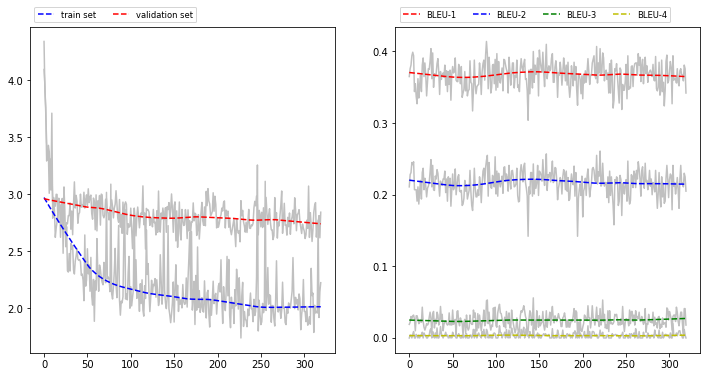

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

with open(log_file, "r") as f:
    log = f.readlines()
    train_list = [x for x in log if "Epoch" in x]
    val_list = [x for x in log if "VALIDATION" in x]

# training dataset
train = {"loss": [], "perplexity": []}
for info in train_list:
    info_splitted = info.split(", ")
    train["loss"].append(float(info_splitted[2][6:12]))
    train["perplexity"].append(float(info_splitted[3][12:20]))

# validation dataset
val = {
    "loss": [],
    "perplexity": [],
    "bleu-1": [],
    "bleu-2": [],
    "bleu-3": [],
    "bleu-4": [],
}
for info in val_list:
    info_splitted = info.split(", ")
    val["loss"].append(float(info_splitted[0][21:27]))
    val["perplexity"].append(float(info_splitted[1][12:20]))
    val["bleu-1"].append(float(info_splitted[2][8:13]))
    val["bleu-2"].append(float(info_splitted[3][8:13]))
    val["bleu-3"].append(float(info_splitted[4][8:13]))
    val["bleu-4"].append(float(info_splitted[5][8:13]))


# plots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(train["loss"], c="silver")
ax[0].plot(val["loss"], c="silver")
ax[1].plot(val["bleu-1"], c="silver")
ax[1].plot(val["bleu-2"], c="silver")
ax[1].plot(val["bleu-3"], c="silver")
ax[1].plot(val["bleu-4"], c="silver")

# trend lines
ys_t = lowess(train["loss"], np.arange(len(train["loss"])), frac=0.33)[:, 1]
ys_v = lowess(val["loss"], np.arange(len(val["loss"])), frac=0.33)[:, 1]
ys_b1 = lowess(val["bleu-1"], np.arange(len(val["loss"])), frac=0.33)[:, 1]
ys_b2 = lowess(val["bleu-2"], np.arange(len(val["loss"])), frac=0.33)[:, 1]
ys_b3 = lowess(val["bleu-3"], np.arange(len(val["loss"])), frac=0.33)[:, 1]
ys_b4 = lowess(val["bleu-4"], np.arange(len(val["loss"])), frac=0.33)[:, 1]
ax[0].plot(np.arange(len(train["loss"])), ys_t, "b--", label="train set")
ax[0].plot(np.arange(len(val["loss"])), ys_v, "r--", label="validation set")
ax[1].plot(np.arange(len(val["loss"])), ys_b1, "r--", label="BLEU-1")
ax[1].plot(np.arange(len(val["loss"])), ys_b2, "b--", label="BLEU-2")
ax[1].plot(np.arange(len(val["loss"])), ys_b3, "g--", label="BLEU-3")
ax[1].plot(np.arange(len(val["loss"])), ys_b4, "y--", label="BLEU-4")
ax[0].legend(ncol=2, bbox_to_anchor=(0, 1), loc="lower left", fontsize="small")
ax[1].legend(ncol=4, bbox_to_anchor=(0, 1), loc="lower left", fontsize="small")

plt.show()

## Future work:

1. Trying Bidirectional LSTM.
2. Trying Attention Models.